In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils

%matplotlib inline

In [4]:
%cd pygranso

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/PyGRANSO


In [5]:
# first party
# Import pygranso functionality
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [6]:
def structural_optimization_function(model, ke, args, designs, debug=False):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )

    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.sparse_displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)
    
    # Run this problem with no inequality constraints
    ci = None
    
    # Run this problem with no equality constraints
    ce = None
    
    designs.append(topo_physics.physical_density(logits, args, volume_constraint=True))
    
    return f, ci, ce

## PyGranso Initializations

This is where we will set up the problem and also the options to run pygranso

In [21]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 5e-5
opts.linesearch_maxit = 50
opts.linesearch_reattempts = 15

In [22]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

  54 ║  - │   -   ║  196.584805207 ║   -  │   -  ║ QN │    13 │ 0.204800 ║     1 │ 0.292732   ║ 
  55 ║  - │   -   ║  196.496738242 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.568465   ║ 
  56 ║  - │   -   ║  196.306295510 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.139699   ║ 
  57 ║  - │   -   ║  196.222461914 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.174068   ║ 
  58 ║  - │   -   ║  195.869382453 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.506249   ║ 
  59 ║  - │   -   ║  195.670969794 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.311847   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
     ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
  60 ║  - │   -   ║  195.6312262

 123 ║  - │   -   ║  194.779011512 ║   -  │   -  ║ QN │    19 │ 13.10720 ║     1 │ 0.218619   ║ 
 124 ║  - │   -   ║  194.777657879 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.202799   ║ 
 125 ║  - │   -   ║  194.776049458 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.149914   ║ 
 126 ║  - │   -   ║  194.775087051 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.176932   ║ 
 127 ║  - │   -   ║  194.773835942 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.190265   ║ 
 128 ║  - │   -   ║  194.773143869 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.098087   ║ 
 129 ║  - │   -   ║  194.772277390 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.046438   ║ 
 130 ║  - │   -   ║  194.771403056 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.201104   ║ 
 131 ║  - │   -   ║  194.769531320 ║   -  │   -  ║ QN │    18 │ 6.553600 ║     1 │ 0.088085   ║ 
 132 ║  - │   -   ║  194.769358326 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.060170   ║ 
 133 ║  - │   -   ║  194.76916

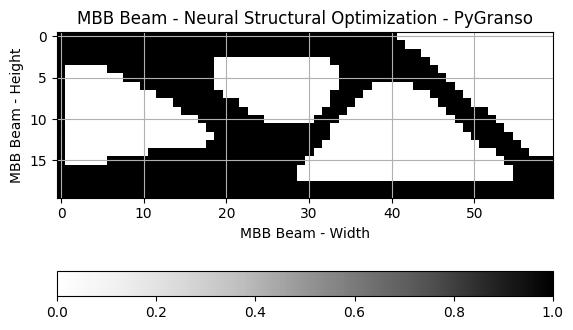

In [23]:
# Get the final frame
final_frame = designs[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - PyGranso')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
ax.grid()
fig.colorbar(im, orientation="horizontal", pad=0.2)

# `PyGranso` Multi-story Building

In [10]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 5e-5
opts.linesearch_maxit = 50

In [11]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

  54 ║  - │   -   ║  45.4891044609 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.088522   ║ 
  55 ║  - │   -   ║  45.3707625026 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.012295   ║ 
  56 ║  - │   -   ║  45.1434342978 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.159910   ║ 
  57 ║  - │   -   ║  44.9684715765 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.033846   ║ 
  58 ║  - │   -   ║  44.8517082794 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.046329   ║ 
  59 ║  - │   -   ║  44.7540802666 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.051334   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
     ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
  60 ║  - │   -   ║  44.63658558

 123 ║  - │   -   ║  39.9042255118 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.034224   ║ 
 124 ║  - │   -   ║  39.8616564263 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.036553   ║ 
 125 ║  - │   -   ║  39.8271981504 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.019363   ║ 
 126 ║  - │   -   ║  39.8096949701 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.060050   ║ 
 127 ║  - │   -   ║  39.7969731932 ║   -  │   -  ║ QN │    16 │ 1.638400 ║     1 │ 0.017151   ║ 
 128 ║  - │   -   ║  39.7679927537 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.507699   ║ 
 129 ║  - │   -   ║  39.7044828208 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.303773   ║ 
 130 ║  - │   -   ║  39.5949284808 ║   -  │   -  ║ QN │    17 │ 3.276800 ║     1 │ 0.299816   ║ 
 131 ║  - │   -   ║  39.5669627270 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.176286   ║ 
 132 ║  - │   -   ║  39.5480424963 ║   -  │   -  ║ QN │    15 │ 0.819200 ║     1 │ 0.011535   ║ 
 133 ║  - │   -   ║  39.542366

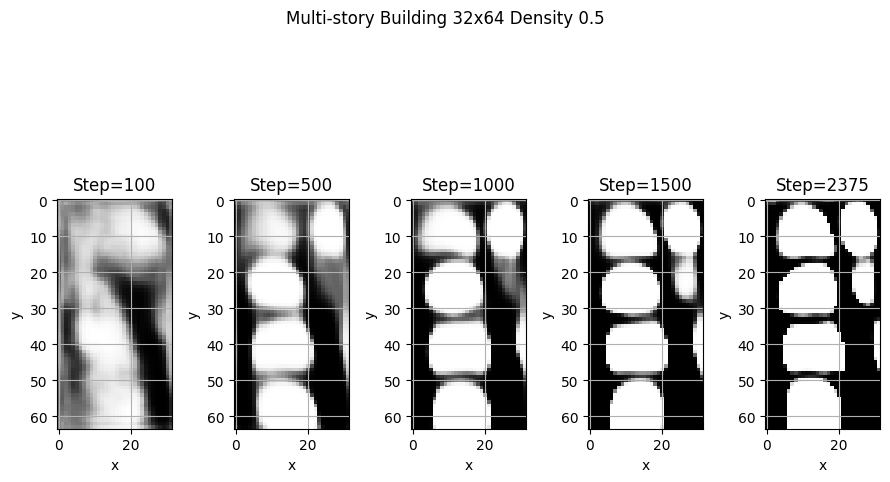

In [12]:
# # Get the final frames
frames = [100, 500, 1000, 1500, len(designs) - 1]

# Create a figure and axis
fig, axes = plt.subplots(1, 5, figsize=(9, 6))
axes = axes.flatten()

for idx, frames in enumerate(frames):
    # Show the structure in grayscale
    im = axes[idx].imshow(designs[frames].detach().numpy(), cmap='Greys')
    axes[idx].set_ylabel('y')
    axes[idx].set_xlabel('x')
    axes[idx].grid()
    axes[idx].set_title(f'Step={frames}')
    
plt.suptitle('Multi-story Building 32x64 Density 0.5')
fig.tight_layout()

In [17]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.PROBLEMS_BY_NAME['thin_support_bridge_128x128_0.2']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 500
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 1e-6
opts.linesearch_maxit = 50
opts.linesearch_reattempts = 15

In [18]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_76050/2654086446.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

  54 ║  - │   -   ║  150.626074310 ║   -  │   -  ║ QN │    21 │ 1.048576 ║     1 │ 0.007899   ║ 
  55 ║  - │   -   ║  149.860151857 ║   -  │   -  ║ QN │    21 │ 1.048576 ║     1 │ 0.005158   ║ 
  56 ║  - │   -   ║  149.488628836 ║   -  │   -  ║ QN │    21 │ 1.048576 ║     1 │ 0.001896   ║ 
  57 ║  - │   -   ║  149.076276808 ║   -  │   -  ║ QN │    21 │ 1.048576 ║     1 │ 0.002999   ║ 
  58 ║  - │   -   ║  148.307832092 ║   -  │   -  ║ QN │    22 │ 2.097152 ║     1 │ 0.009194   ║ 
  59 ║  - │   -   ║  146.541939692 ║   -  │   -  ║ QN │    23 │ 4.194304 ║     1 │ 0.044583   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
     ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
  60 ║  - │   -   ║  145.5451811

In [19]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


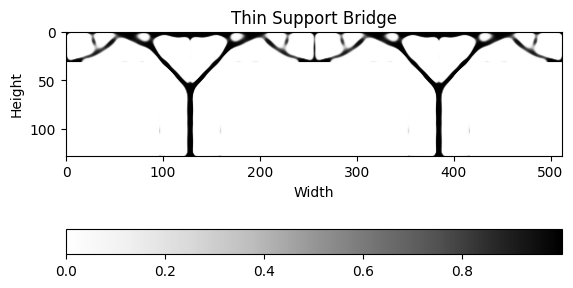

In [20]:
# Get the final frame
final_frame = designs[-1].detach().numpy()
reversed_frame = final_frame[:, ::-1]
bridge_frame = np.hstack([final_frame, reversed_frame] * 2)

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(bridge_frame, cmap='Greys')
ax.set_title('Thin Support Bridge')
ax.set_ylabel('Height')
ax.set_xlabel('Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)

# Try learning the `u_matrix`

In [ ]:
def structural_optimization_function(model, u_nonzero, ke, args, designs, debug=False):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = cnn_model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )

    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Instead of calculating u_matrix let's see if we can learn it
    # Calculate the stiffness matrix
    stiffness = topo_physics.young_modulus(
        x_phys, e_min=args['young_min'], e_0=args['young'], p=args['penal'],
    )
    
    # Define freedofs and fixdofs
    freedofs = args['freedofs']
    fixdofs = args['fixdofs']
    
    # Get the K values
    k_entries, k_ylist, k_xlist = topo_physics.get_k(stiffness, ke)

    index_map, keep, indices = utils._get_dof_indices(
        freedofs, fixdofs, k_ylist, k_xlist
    )

    # Reduced forces
    freedofs_forces = forces[freedofs].double()

    # K matrix based on the size of forces[freedofs]
    K = (
        torch.sparse_coo_tensor(
            indices, k_entries[keep], (len(freedofs_forces),) * 2
        ).to_dense()
    ).double()
    K = (K + K.transpose(1, 0)) / 2.0
    
    # Create the full u_matrix
    len_fixdofs = len(fixdofs)
    u_matrix = torch.cat((u_nonzero, torch.zeros(len_fixdofs)))
    u_matrix = u_matrix[index_map]
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)
    
    # Run this problem with no inequality constraints
    ci = None
    
    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = torch.sum(torch.abs(K @ u_nonzero - freedofs_forces))
    
    designs.append(topo_physics.physical_density(logits, args, volume_constraint=True))
    
    return f, ci, ce

In [ ]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1), train_u_matrix=True)

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Set up u_matrix
u_nonzero = list(cnn_model.parameters())[0]

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, u_nonzero, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 3500
opts.print_frequency = 1
opts.stat_l2_model = False

In [ ]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

In [ ]:
# Get the final frame
final_frame = designs[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - PyGranso')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
ax.grid()
fig.colorbar(im, orientation="horizontal", pad=0.2)